# Stock Prediction

In this project, I used a Recurrent Neural Network regressor with the Long Term Short Memory model and time series to predict the stock price of American Airlines (AAL) in 2020.

LTSM is used avoid technical problems with optimization of RNNs.

# 1. Load Data

The input data is a time series data from 2013 to 2018 of different stock tickers. The data is initially normalized using a minmax normalizer.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# cd /content/drive/MyDrive/Colab Notebooks/Projects/Stock LSTM/

/content/drive/MyDrive/Colab Notebooks/Projects/Stock LSTM


In [3]:
# !ls

all_stocks_5yr.csv  stock_prediction_lstm.ipynb


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [5]:
# Importing the training set
dataset = pd.read_csv('./all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='AAL'].close.values

In [6]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

# 2.  Cutting our time series into sequences

The time series stock price data are split into sequnces (windows) of length $L$, starting at time $t$, and end at time $t + L - 1$, as inputs to the LSTM neural network. The outputs that the model is trying to predict are the stock prices at time $t+L$.

For example, using a window of size T = 3, the set of input/output pairs are like the table below:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3}\rangle} & \color{Goldenrod}{ s_{4}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4} \rangle } & \color{Goldenrod} {s_{5} } \\
\color{CornflowerBlue} {\langle s_{3},s_{4},s_{5} \rangle } & \color{Goldenrod} {s_{6} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{t-3},s_{t-2},s_{t-1} \rangle } & \color{Goldenrod} {s_{t}}
\end{array}$$

In [7]:
# The model here uses a 5-day look back (L=5) for the model
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)

X, y = processData(dataset_cl, 5)


# 3. Split Training and Evaluation datasets

Since the dataset is a time series data, the data is split temporally. The earliest 80% of the dataset are used as the training dataset and the last 20% are used as evaluation

In [8]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 4. Build and run a RNN regression model

The RNN is built with 2 hidden layers using Keras:

- layer 1 uses an LSTM module with 5 hidden units (the input_shape = (L,1))
- layer 2 uses a fully connected module with 1 hidden unit
- the loss used is MSE

In [9]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [28]:
# Global Variables

INPUT_SIZE = 5
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128

# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [29]:
rnn

RNN(
  (rnn): LSTM(5, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [32]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state)
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters

    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.3515038788318634, eval loss 0.6272391080856323
epoch 1, loss 0.32347118854522705
epoch 2, loss 0.2956629991531372
epoch 3, loss 0.267718642950058
epoch 4, loss 0.23868872225284576
epoch 5, loss 0.2086697518825531
epoch 6, loss 0.1770830601453781
epoch 7, loss 0.1436043381690979
epoch 8, loss 0.1095663458108902
epoch 9, loss 0.0765763446688652
epoch 10, loss 0.04922741279006004
epoch 11, loss 0.03647806495428085
epoch 12, loss 0.05569642782211304
epoch 13, loss 0.07544367015361786
epoch 14, loss 0.07366419583559036
epoch 15, loss 0.05799049139022827
epoch 16, loss 0.04414261877536774
epoch 17, loss 0.0371217355132103
epoch 18, loss 0.03585188090801239
epoch 19, loss 0.03847205266356468
epoch 20, loss 0.041350800544023514, eval loss 0.09909164160490036
epoch 21, loss 0.0440436415374279
epoch 22, loss 0.04500586912035942
epoch 23, loss 0.04483380913734436
epoch 24, loss 0.04375418275594711
epoch 25, loss 0.040898311883211136
epoch 26, loss 0.03745722025632858
epoch 27, los

In [33]:
rnn.out.weight

Parameter containing:
tensor([[ 0.0993,  0.0608,  0.0330, -0.0915,  0.0231, -0.0889,  0.0817,  0.0983,
         -0.1113,  0.0092,  0.0550,  0.1351,  0.0337, -0.0560,  0.0237,  0.0488,
          0.0581, -0.0117, -0.0163, -0.0008, -0.1035,  0.1217,  0.0702,  0.1192,
         -0.0679, -0.0582,  0.0647, -0.0109, -0.0547, -0.1096, -0.0029, -0.0146,
          0.0278, -0.0745, -0.0366,  0.0838, -0.1151, -0.0761, -0.0343, -0.0935,
          0.0513, -0.0379, -0.0200, -0.0400,  0.0684,  0.0885, -0.0874, -0.0357,
         -0.0703, -0.0533, -0.0640, -0.0354,  0.0862,  0.0602,  0.0075,  0.0449,
          0.1116, -0.0010,  0.0071,  0.1078, -0.0588,  0.1038, -0.1062, -0.0049]],
       device='cuda:0', requires_grad=True)

In [34]:
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.1181,  0.0282, -0.0220,  0.1304,  0.0342],
        [ 0.0857,  0.0255,  0.0891, -0.0456,  0.1136],
        [-0.0118, -0.0082,  0.0446, -0.0778,  0.1277],
        ...,
        [-0.0823,  0.0913,  0.1196,  0.1356, -0.0488],
        [-0.1163, -0.0060,  0.0870, -0.0721,  0.0323],
        [-0.0723, -0.0349,  0.0462, -0.0467,  0.0846]], device='cuda:0')
tensor([[ 0.0659,  0.1355,  0.0500,  ..., -0.1031, -0.0935, -0.0433],
        [ 0.0934,  0.0599, -0.0346,  ..., -0.1406, -0.0756,  0.0235],
        [ 0.0759, -0.0094,  0.0634,  ..., -0.0759,  0.1163, -0.0421],
        ...,
        [ 0.0844,  0.1118,  0.0305,  ...,  0.0130, -0.0770, -0.0550],
        [ 0.0862,  0.1334, -0.1227,  ..., -0.0200, -0.0101, -0.0730],
        [-0.0658, -0.0970,  0.0106,  ..., -0.0608, -0.0532, -0.0164]],
       device='cuda:0')
tensor([-0.0697,  0.1372,  0.0640,  0.1185, -0.0777,  0.0893,  0.1015,  0.1402,
         0.0717,  0.1012,  0.1154,  0.0881, -0.0335, -0.0075, -0.0961, -0.0485,
        -0.0401, -0.0

# 5. Model Evaluation

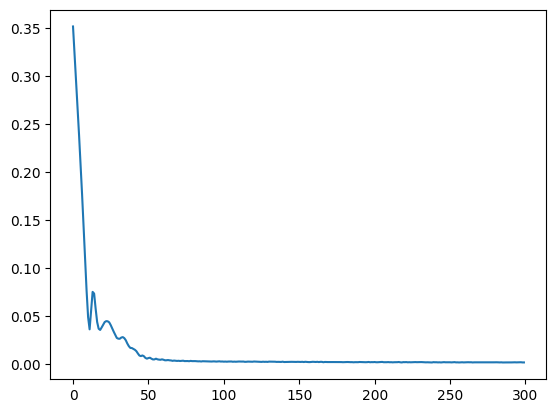

In [38]:
plt.plot(history)

In [19]:
X_test[0]

array([[0.68272827, 0.68184818, 0.6860286 , 0.71023102, 0.70737074]])

In [43]:
rnn.eval()

test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [40]:
test_predict_cpu.shape

(251, 1, 1)

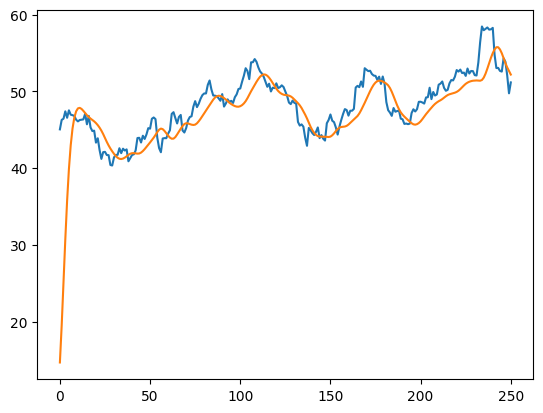

In [41]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

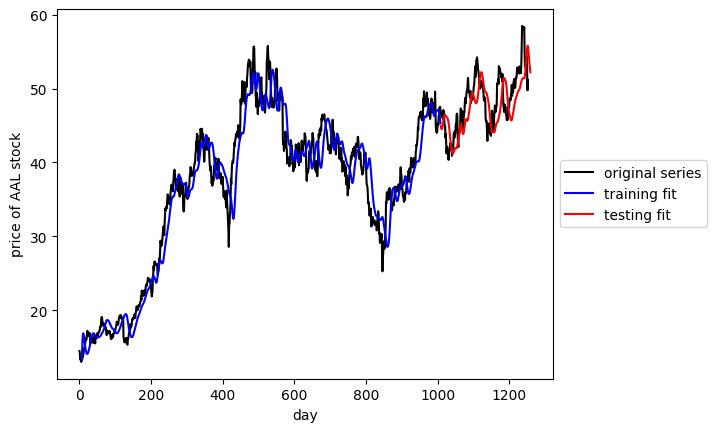

In [44]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of AAL stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
